In [54]:
import warnings
warnings.filterwarnings('ignore')

import scanpy as sc

from wcd_vae.data import prep_data
from wcd_vae.metrics import ilisi_graph, clisi_graph
from wcd_vae.scCRAFT.model import train_integration_model, obtain_embeddings
from wcd_vae.scCRAFT.utils import set_seed
from wcd_vae.plot import plot_umap_by_technology

import numpy as np
import torch
from sklearn.model_selection import train_test_split

# set random seed for reproducibility
set_seed(42)

In [ ]:
confounding_key_map = {
    'inDrop3': 'inDrop-Seq',
    'smartseq2': 'Smart-Seq'
}

cell_type_key_map = {
    'acinar': 'Acinar',
    'activated_stellate': 'Activated Stellate',
    'alpha': 'Alpha',
    'beta': 'Beta',
    'delta': 'Delta',
    'gamma': 'Gamma',
    'ductal': 'Ductal',
    'acinar': 'Acinar',
    'endothelial': 'Endothelial',
    'epsilon': 'Epsilon',
    'macrophage': 'Macrophage',
    'mast': 'Mast',
    'quiescent_stellate': 'Quiescent Stellate',
    'schwann': 'Schwann',
    't_cell': 'T Cell',
    'macrophage': 'Macrophage'
}

# Pancreas

In [55]:
pancreas_adata = prep_data("/workspaces/data/human_pancreas_norm_complexBatch.h5ad", 
                  batch_key="tech", 
                  celltype_key="celltype",
                  batch_count=2,
                  min_genes=300,
                  min_cells=5,
                  norm_val=1e4,
                  n_top_genes=2000, 
                  balance=False)

Before deconfounding

In [77]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 

# (Imports from your other modules would be at the top of the script)

def plot_2x2_comparison(
    adata,
    batch_key="tech",
    color_key="celltype",
    s=10, # Scatter dot size
    # --- Parameters for customization ---
    batch_key_map=None,
    color_key_map=None,
    save_path=None
):
    """
    Generates a 2x2 UMAP comparison plot specifically for two technologies.

    - Top-Left: UMAP of Tech 1, colored by cell type.
    - Top-Right: UMAP of Tech 2, colored by cell type.
    - Bottom-Left: Combined UMAP, colored by technology.
    - Bottom-Right: Combined UMAP, colored by cell type.
    
    This function requires exactly two unique categories in adata.obs[batch_key].

    Parameters:
    -----------
    adata : AnnData
        Annotated data object.
    batch_key : str, default 'tech'
        Key in adata.obs containing batch/technology information.
    color_key : str, default 'celltype'
        Key in adata.obs for coloring points.
    s : int, default 10
        Dot size for scatter plots.
    batch_key_map : dict, optional
        Dictionary to rename batch_key labels in legends.
    color_key_map : dict, optional
        Dictionary to rename color_key labels in legends.
    save_path : str, optional
        File path to save the 2x2 grid plot (e.g., "plot_2x2_comparison.png").
    """
    print("Generating 2x2 comparison plot...")
    
    # --- 1. Compute UMAP if not present ---
    if "X_umap" not in adata.obsm:
        print("Calculating UMAP...")
        sc.tl.umap(adata, min_dist=0.5)

    # --- 2. Ensure keys are categorical ---
    if not pd.api.types.is_categorical_dtype(adata.obs[color_key]):
        adata.obs[color_key] = adata.obs[color_key].astype("category")
    if not pd.api.types.is_categorical_dtype(adata.obs[batch_key]):
        adata.obs[batch_key] = adata.obs[batch_key].astype("category")

    # --- 3. VALIDATION: Check for exactly two technologies ---
    technologies = adata.obs[batch_key].cat.categories
    if len(technologies) != 2:
        raise ValueError(
            f"Error: This function requires exactly 2 categories in '{batch_key}'. "
            f"Found {len(technologies)}: {list(technologies)}"
        )
    tech1, tech2 = technologies[0], technologies[1]

    # --- 4. Set up consistent, high-contrast colors ---
    
    # 4a. For color_key (Cell Type)
    cell_categories = adata.obs[color_key].cat.categories
    num_cell_categories = len(cell_categories)
    
    if num_cell_categories <= 20 and hasattr(sc.pl.palettes, 'default_20'):
        cell_colors = sc.pl.palettes.default_20[:num_cell_categories]
    elif num_cell_categories <= 102 and hasattr(sc.pl.palettes, 'default_102'):
        cell_colors = sc.pl.palettes.default_102[:num_cell_categories]
    else: 
        print(f"Warning: Using 'tab20' colormap and cycling colors for "
              f"{num_cell_categories} cell types.")
        cmap = plt.cm.get_cmap('tab20')
        cell_colors = [cmap(i % 20) for i in range(num_cell_categories)]
        
    adata.uns[f'{color_key}_colors'] = cell_colors

    # 4b. For batch_key (Technology)
    batch_categories = adata.obs[batch_key].cat.categories
    num_batch_categories = len(batch_categories)
    
    cmap = plt.cm.get_cmap('tab10')
    batch_colors = [cmap(i % 10) for i in range(num_batch_categories)]
    
    adata.uns[f'{batch_key}_colors'] = batch_colors

    # --- 5. Get overall UMAP limits for consistent scaling ---
    x_coords = adata.obsm["X_umap"][:, 0]
    y_coords = adata.obsm["X_umap"][:, 1]
    x_min, x_max = x_coords.min() - 0.5, x_coords.max() + 0.5
    y_min, y_max = y_coords.min() - 0.5, y_coords.max() + 0.5
    
    # Get labels for titles, applying map if it exists
    tech1_label = batch_key_map.get(tech1, tech1) if batch_key_map else tech1
    tech2_label = batch_key_map.get(tech2, tech2) if batch_key_map else tech2

    # --- 6. Create the 2x2 Figure ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle("Two-Technology UMAP Comparison", fontsize=20, y=0.95)

    # --- Top-Left: Tech 1 by Cell Type ---
    sc.pl.umap(
        adata[adata.obs[batch_key] == tech1],
        color=color_key,
        ax=axes[0, 0],
        show=False,
        legend_loc=None,
        s=s,
        title=str(tech1_label) # Use mapped label
    )

    # --- Top-Right: Tech 2 by Cell Type ---
    sc.pl.umap(
        adata[adata.obs[batch_key] == tech2],
        color=color_key,
        ax=axes[0, 1],
        show=False,
        legend_loc=None,
        s=s,
        title=str(tech2_label) # Use mapped label
    )
    
    # --- Bottom-Left: Combined by Tech ---
    sc.pl.umap(
        adata,
        color=batch_key,
        ax=axes[1, 0],
        show=False,
        legend_loc=None,
        s=s,
        title=f"Combined (Colored by Technology)"
    )

    # --- Bottom-Right: Combined by Cell Type ---
    sc.pl.umap(
        adata,
        color=color_key,
        ax=axes[1, 1],
        show=False,
        legend_loc=None,
        s=s,
        title=f"Combined (Colored by Cell Type)"
    )

    # --- 7. Standardize all axis limits and remove labels ---
    for ax in axes.flatten():
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        # --- MODIFIED: Remove axis labels ---
        ax.set_xlabel(None)
        ax.set_ylabel(None)

    # --- 8. Create Shared Legends (Dual-Legend System) ---
    
    # Get handles for Technology legend
    batch_handles = [Line2D([0], [0], marker='o', color=c, 
                           label=batch_key_map.get(l, l) if batch_key_map else l, 
                           linestyle='None')
                     for l, c in zip(batch_categories, batch_colors)]
    
    # Get handles for Cell Type legend
    cell_handles = [Line2D([0], [0], marker='o', color=c, 
                          label=color_key_map.get(l, l) if color_key_map else l, 
                          linestyle='None')
                    for l, c in zip(cell_categories, cell_colors)]
    
    # Adjust layout to make space
    plt.tight_layout(rect=[0.1, 0.05, 0.9, 0.95]) 
    
    # Add Technology legend (LEFT)
    fig.legend(
        handles=batch_handles, 
        loc='center left', 
        bbox_to_anchor=(0.01, 0.5), # Position on left
        title=batch_key.capitalize(), 
        frameon=False
    )
    # Add Cell Type legend (RIGHT)
    fig.legend(
        handles=cell_handles, 
        loc='center right', 
        bbox_to_anchor=(1.01, 0.5), # Position on right
        title=color_key.capitalize(), 
        frameon=False,
        ncol=1 
    )

    if save_path:
        print(f"Saving 2x2 plot to {save_path}...")
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

Generating 2x2 comparison plot...
Saving 2x2 plot to pancreas_2x2_comparison.png...


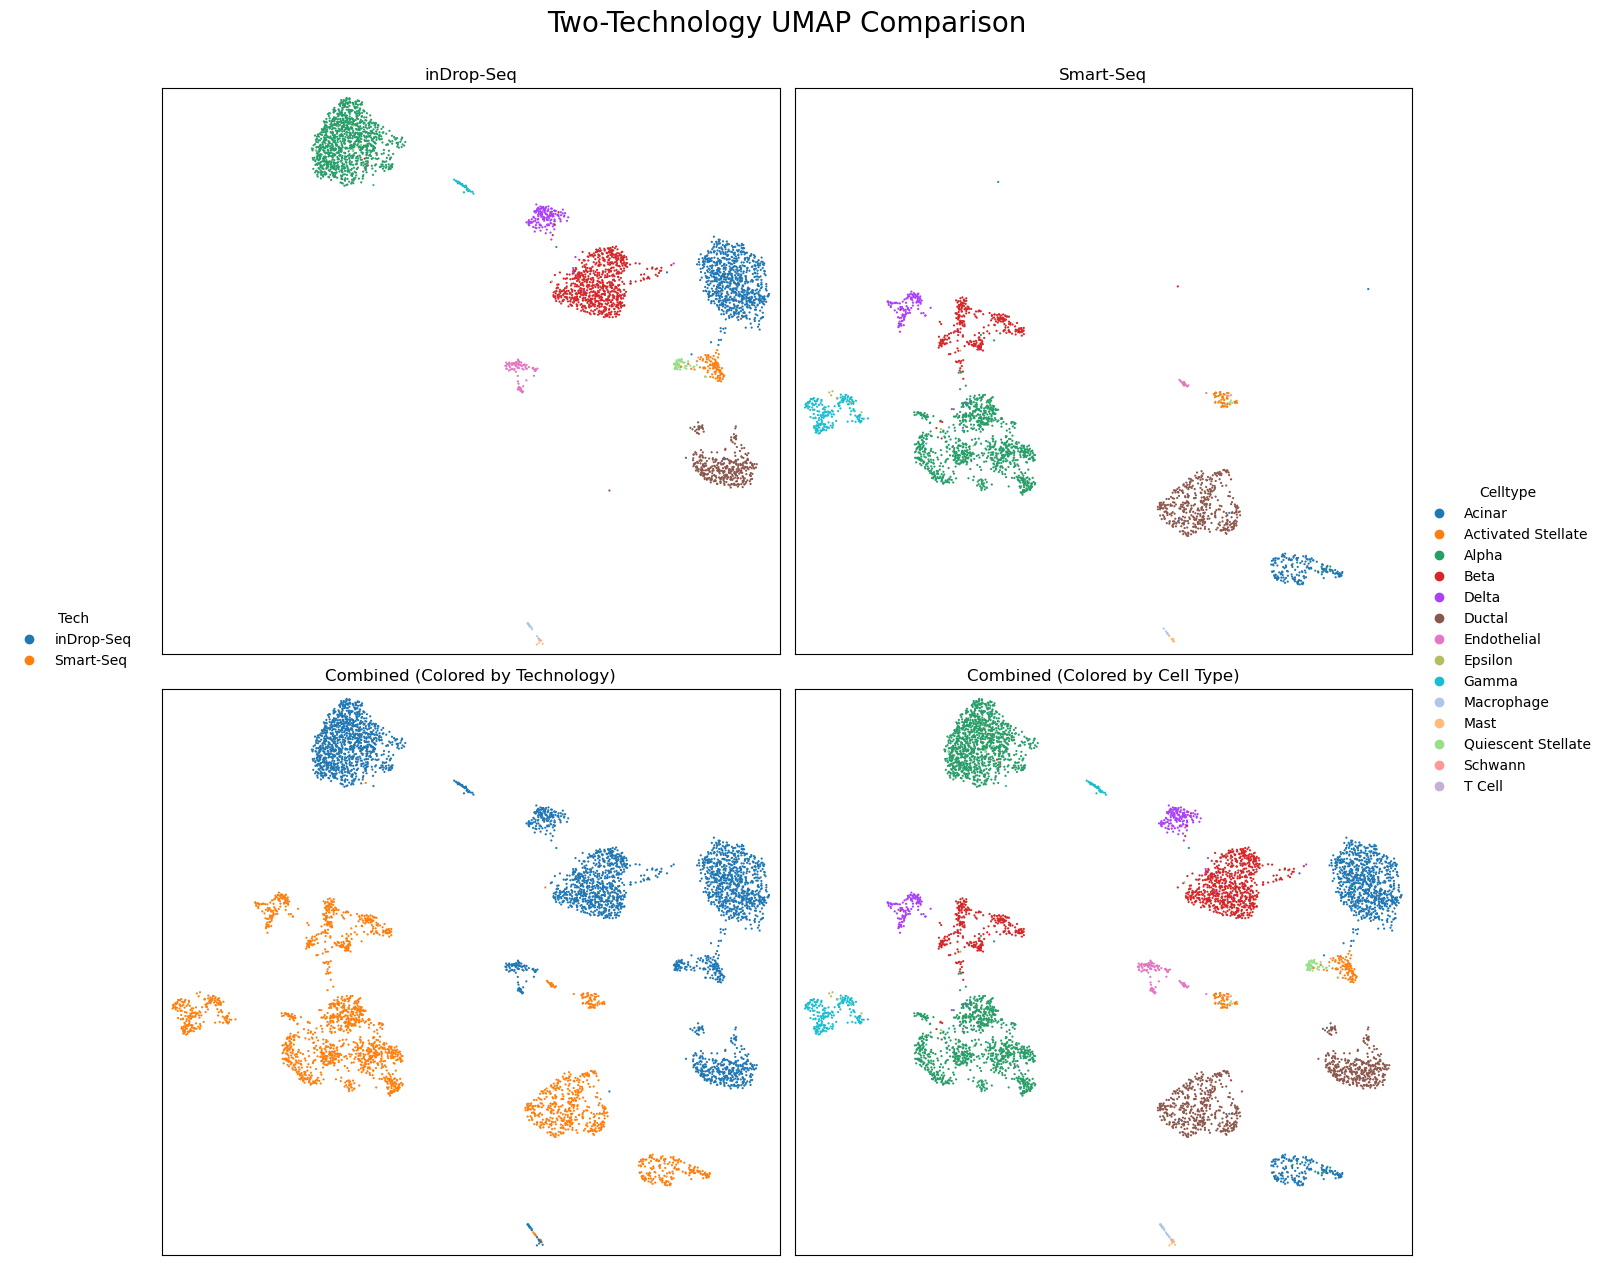

In [ ]:
plot_2x2_comparison(
    pancreas_adata,
    batch_key="tech",
    color_key="celltype",
    s=10,
    batch_key_map=confounding_key_map,
    color_key_map=cell_type_key_map,
    save_path="results/pancreas_2x2_comparison.png"
)

Train model with Wasserstein Critic and plot UMAP

In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
from anndata import AnnData
from typing import List, Optional, Dict
import os

import scanpy as sc
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 

def train_and_compare_plots(adata, cell_type_key='celltype', confounding_key='tech', 
                            # Set defaults based on your CV results
                            d_coef_critic=0.1, 
                            d_coef_discriminator=0.05, 
                            epochs=500,
                            # --- PARAMETERS ADDED ---
                            confounding_key_map=None,
                            cell_type_key_map=None):
    
    # --- 1. Train/Test Split ---
    indices = np.arange(adata.n_obs)
    labels = adata.obs[cell_type_key]
    train_idx, test_idx = train_test_split(
        indices, 
        test_size=0.2, 
        stratify=labels, 
        random_state=42
    )

    adata_train = adata[train_idx].copy()
    adata_test = adata[test_idx].copy()

    print(f"Full data: {adata.n_obs} cells")
    print(f"Train data: {adata_train.n_obs} cells")
    print(f"Test data: {adata_test.n_obs} cells")
    
    # --- Ensure keys are categorical for consistent colors ---
    adata_train.obs[cell_type_key] = adata_train.obs[cell_type_key].astype('category')
    adata_train.obs[confounding_key] = adata_train.obs[confounding_key].astype('category')
    adata_test.obs[cell_type_key] = adata_test.obs[cell_type_key].astype('category')
    adata_test.obs[confounding_key] = adata_test.obs[confounding_key].astype('category')

    # --- 2. Train CRITIC Model ---
    print("\n--- Training Critic Model ---")
    model_critic = train_integration_model(
        adata_train.copy(), 
        batch_key=confounding_key, 
        z_dim=256, 
        d_coef=d_coef_critic, 
        epochs=epochs, 
        critic=True, 
        disc_iter=10
    )
    
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model_critic.to(device)
    adata_train_crit = adata_train.copy()
    adata_test_crit = adata_test.copy()
    obtain_embeddings(adata_train_crit, model_critic)
    obtain_embeddings(adata_test_crit, model_critic)
    print("Critic embeddings obtained.")

    # --- 3. Train DISCRIMINATOR Model ---
    print("\n--- Training Discriminator Model ---")
    model_disc = train_integration_model(
        adata_train.copy(), 
        batch_key=confounding_key, 
        z_dim=256, 
        d_coef=d_coef_discriminator, 
        epochs=epochs, 
        critic=False, 
        disc_iter=1
    )
    
    model_disc.to(device)
    adata_train_disc = adata_train.copy()
    adata_test_disc = adata_test.copy()
    obtain_embeddings(adata_train_disc, model_disc)
    obtain_embeddings(adata_test_disc, model_disc)
    print("Discriminator embeddings obtained.")

    # --- 4. Calculate LISI Scores ---
    print("\nCalculating LISI scores on held-out test sets...")
    
    # Critic LISI
    adata_crit_comb = adata_train_crit.concatenate(adata_test_crit)
    test_idx_comb = np.arange(adata_train_crit.n_obs, adata_crit_comb.n_obs)
    sc.pp.neighbors(adata_crit_comb, use_rep="X_scCRAFT")
    ilisi_crit = ilisi_graph(adata_crit_comb, batch_key=confounding_key, 
                           type="embed", use_rep="X_scCRAFT", subset_indices=test_idx_comb)
    clisi_crit = clisi_graph(adata_crit_comb, label_key=cell_type_key, 
                           type="embed", use_rep="X_scCRAFT", subset_indices=test_idx_comb)

    # Discriminator LISI
    adata_disc_comb = adata_train_disc.concatenate(adata_test_disc)
    sc.pp.neighbors(adata_disc_comb, use_rep="X_scCRAFT")
    ilisi_disc = ilisi_graph(adata_disc_comb, batch_key=confounding_key, 
                           type="embed", use_rep="X_scCRAFT", subset_indices=test_idx_comb)
    clisi_disc = clisi_graph(adata_disc_comb, label_key=cell_type_key, 
                           type="embed", use_rep="X_scCRAFT", subset_indices=test_idx_comb)

    # --- 5. Print Results ---
    print("\n--- Held-Out Test Set Results ---")
    print(f"Critic:       iLISI = {ilisi_crit:.4f}, cLISI = {clisi_crit:.4f}")
    print(f"Discriminator: iLISI = {ilisi_disc:.4f}, cLISI = {clisi_disc:.4f}")

    # --- 6. Plotting (2x2 Grid + Shared Legends) ---
    print("Generating comparison UMAPs for TEST data...")
    
    sc.tl.umap(adata_crit_comb)
    sc.tl.umap(adata_disc_comb)
    
    adata_crit_test_plot = adata_crit_comb[test_idx_comb].copy()
    adata_disc_test_plot = adata_disc_comb[test_idx_comb].copy()
    
    # --- Set up consistent, high-contrast colors ---
    
    # --- 1. For cell_type_key (NEW LOGIC) ---
    cell_categories = adata_crit_test_plot.obs[cell_type_key].cat.categories
    num_cell_categories = len(cell_categories)
    
    if num_cell_categories <= 20 and hasattr(sc.pl.palettes, 'default_20'):
        # Use default_20 (tab20) for smaller, distinct sets
        cell_colors = sc.pl.palettes.default_20[:num_cell_categories]
    elif num_cell_categories <= 102 and hasattr(sc.pl.palettes, 'default_102'):
        # Use default_102 for large sets
        cell_colors = sc.pl.palettes.default_102[:num_cell_categories]
    else: 
        # Fallback for >102 or missing palettes: cycle a good colormap
        # This avoids 'turbo' (sequential) and bright yellow.
        print(f"Warning: Using 'tab20' colormap and cycling colors for "
              f"{num_cell_categories} cell types.")
        cmap = plt.cm.get_cmap('tab20')
        cell_colors = [cmap(i % 20) for i in range(num_cell_categories)]
        
    adata_crit_test_plot.uns[f'{cell_type_key}_colors'] = cell_colors

    # --- 2. For confounding_key (Technology) (NEW LOGIC) ---
    batch_categories = adata_crit_test_plot.obs[confounding_key].cat.categories
    num_batch_categories = len(batch_categories)
    
    # Use 'tab10' and cycle it, robust for any number of categories
    cmap = plt.cm.get_cmap('tab10')
    batch_colors = [cmap(i % 10) for i in range(num_batch_categories)]
    
    adata_crit_test_plot.uns[f'{confounding_key}_colors'] = batch_colors
    
    # Copy colors to discriminator plot to ensure they match
    adata_disc_test_plot.uns[f'{cell_type_key}_colors'] = adata_crit_test_plot.uns[f'{cell_type_key}_colors']
    adata_disc_test_plot.uns[f'{confounding_key}_colors'] = adata_crit_test_plot.uns[f'{confounding_key}_colors']
    
    # --- Create the 2x2 figure ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    fig.suptitle("Model Comparison on Held-Out Test Data", fontsize=20, y=0.95)
    
    # --- Critic Plots (Top Row) ---
    sc.pl.umap(adata_crit_test_plot, 
               color=confounding_key, 
               ax=axes[0, 0], 
               show=False, 
               legend_loc=None,
               title="")

    sc.pl.umap(adata_crit_test_plot, 
               color=cell_type_key, 
               ax=axes[0, 1], 
               show=False, 
               legend_loc=None,
               title="")
    
    # --- Discriminator Plots (Bottom Row) ---
    sc.pl.umap(adata_disc_test_plot, 
               color=confounding_key, 
               ax=axes[1, 0], 
               show=False, 
               legend_loc=None,
               title="")
    sc.pl.umap(adata_disc_test_plot, 
               color=cell_type_key, 
               ax=axes[1, 1], 
               show=False, 
               legend_loc=None,
               title="")
    
    # --- 6b. Add Shared Axis Labels & Row Labels ---
    
    # Clear all default labels
    for ax in axes.flatten():
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    
    # Add shared X-axis labels (bottom row)
    axes[1, 0].set_xlabel("Technology", fontsize=16, fontweight='bold')
    axes[1, 1].set_xlabel("Cell Type", fontsize=16, fontweight='bold')

    # Add shared Y-axis labels (left col) + Row Titles
    axes[0, 0].set_ylabel("Critic", fontsize=16, fontweight='bold')
    axes[1, 0].set_ylabel("Discriminator", fontsize=16, fontweight='bold')
    
    # --- 6c. Create Shared Legends (Left and Right) ---
    
    # Get handles for Technology legend
    # --- MODIFIED: Use mapping if provided ---
    batch_handles = [Line2D([0], [0], marker='o', color=c, 
                           label=confounding_key_map.get(l, l) if confounding_key_map else l, 
                           linestyle='None')
                     for l, c in zip(batch_categories, batch_colors)]
    
    # Get handles for Cell Type legend
    # --- MODIFIED: Use mapping if provided ---
    cell_handles = [Line2D([0], [0], marker='o', color=c, 
                          label=cell_type_key_map.get(l, l) if cell_type_key_map else l, 
                          linestyle='None')
                    for l, c in zip(cell_categories, cell_colors)]
    
    # Adjust layout to make space on left and right
    plt.tight_layout(rect=[0.1, 0.05, 0.9, 0.95]) 
    
    # Add Technology legend (LEFT)
    leg1 = fig.legend(
        handles=batch_handles, 
        loc='center left', 
        bbox_to_anchor=(0.01, 0.5), # Position on left
        title="Technology", 
        frameon=False
    )
    # Add Cell Type legend (RIGHT)
    leg2 = fig.legend(
        handles=cell_handles, 
        loc='center right', 
        bbox_to_anchor=(1.01, 0.5), # Position on right
        title="Cell Type", 
        frameon=False,
        ncol=1 
    )

    plt.savefig("results/comparison_umap.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Return all the data
    return {
        "critic": {"ilisi": ilisi_crit, "clisi": clisi_crit, "adata_combined": adata_crit_comb},
        "discriminator": {"ilisi": ilisi_disc, "clisi": clisi_disc, "adata_combined": adata_disc_comb}
    }

Full data: 5999 cells
Train data: 4799 cells
Test data: 1200 cells

--- Training Critic Model ---
Using device: cuda
500
Training completed in 56.10 seconds
Critic embeddings obtained.

--- Training Discriminator Model ---
Using device: cuda
500
Training completed in 44.04 seconds
Discriminator embeddings obtained.

Calculating LISI scores on held-out test sets...
Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for tech...
Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for celltype...
Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for tech...
Using embed
Computing LISI
Computing 90 nearest neighbors for 5999 cells...
Computing LISI scores for celltype...

--- Held-Out Test Set Results ---
Critic:       iLISI = 0.7284, cLISI = 0.0433
Discriminator: iLISI = 0.5990, cLISI = 0.0217
Generating comparison UMAPs for TEST data...


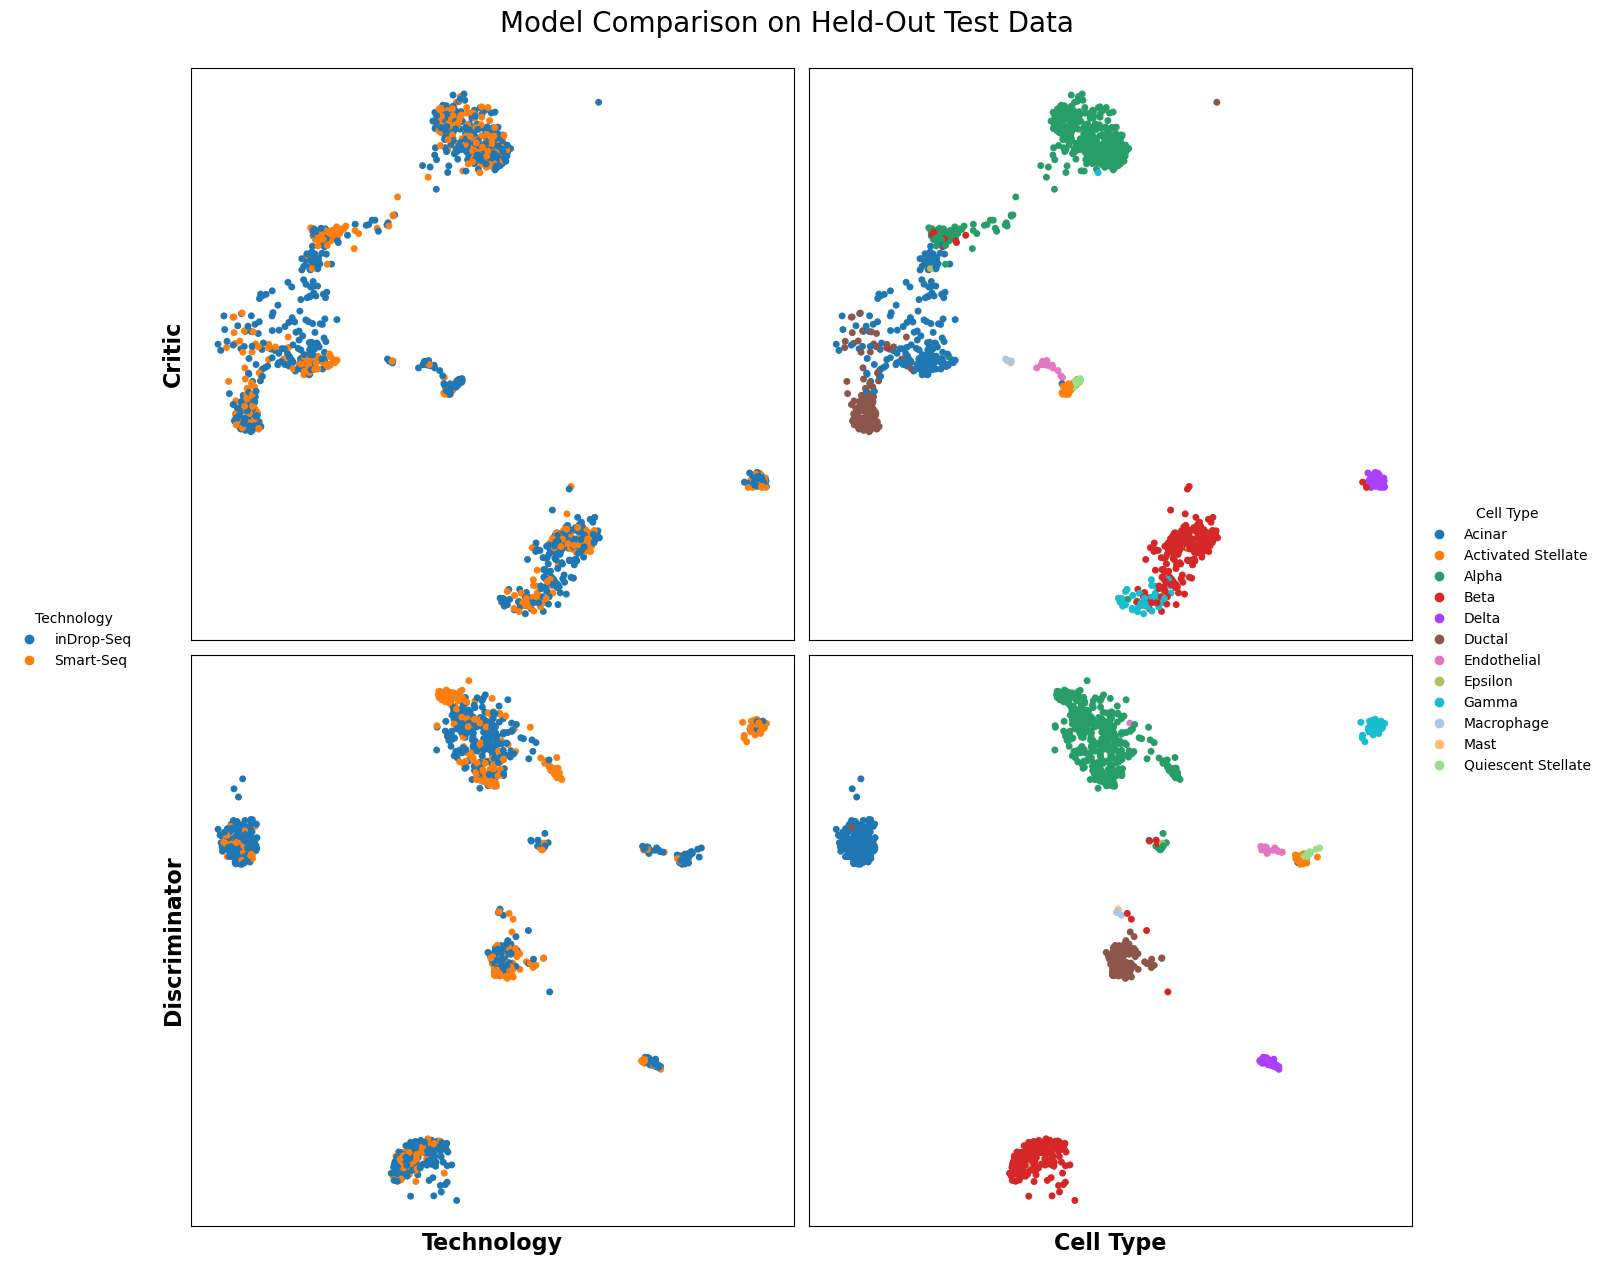

{'critic': {'ilisi': np.float64(0.7283733892890722),
  'clisi': np.float64(0.04330522223878283),
  'adata_combined': AnnData object with n_obs × n_vars = 5999 × 2000
      obs: 'tech', 'celltype', 'size_factors', 'n_genes', 'n_counts', 'leiden', 'leiden1', 'leiden2', 'batch'
      var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns: 'neighbors', 'umap'
      obsm: 'X_pca', 'X_umap', 'X_scCRAFT'
      layers: 'counts'
      obsp: 'distances', 'connectivities'},
 'discriminator': {'ilisi': np.float64(0.5989530979297317),
  'clisi': np.float64(0.0216946115028745),
  'adata_combined': AnnData object with n_obs × n_vars = 5999 × 2000
      obs: 'tech', 'celltype', 'size_factors', 'n_genes', 'n_counts', 'leiden', 'leiden1', 'leiden2', 'batch'
      var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
      uns: 'n

In [ ]:
train_and_compare_plots(pancreas_adata, cell_type_key='celltype', confounding_key='tech', d_coef_critic=0.05, d_coef_discriminator=0.1, epochs=500, confounding_key_map=confounding_key_map, cell_type_key_map=cell_type_key_map)

# Lung

In [59]:
lung_adata = prep_data("/workspaces/data/Lung_atlas_public.h5ad", 
                  batch_key="protocol", 
                  celltype_key="cell_type",
                  batch_count=2,
                  min_genes=300,
                  min_cells=5,
                  norm_val=1e4,
                  n_top_genes=2000, 
                  balance=False)

# Immune

In [60]:
immune_adata = prep_data("/workspaces/data/Immune_ALL_human.h5ad", 
                  batch_key="chemistry", 
                  celltype_key="final_annotation",
                  batch_count=2,
                  min_genes=300,
                  min_cells=5,
                  norm_val=1e4,
                  n_top_genes=2000, 
                  balance=False)

# Data Summary Table

In [61]:
def generate_combined_adata_table(
    adata_list: List[AnnData], 
    protocol_keys: List[str], 
    save_path: str,
    dataset_names: Optional[List[str]] = None,
    tech_name_map: Optional[Dict[str, str]] = None
) -> str:
    """
    Generates a single, combined, and centered LaTeX table and saves it to a file.

    The table lists each dataset, its technologies (with names mapped if provided), 
    a sub-total, and a grand total.

    Args:
        adata_list: A list of loaded AnnData objects.
        protocol_keys: A list of strings, where each string is the .obs key 
                         for the protocol in the corresponding AnnData object.
        save_path: The file path to write the .tex file (e.g., "my_table.tex").
        dataset_names: An optional list of strings to name each dataset.
        tech_name_map: An optional dictionary to map raw technology names
                         (e.g., "10x_v3") to display names (e.g., "10x Chromium v3").

    Returns:
        The LaTeX table as a string.
    """
    
    # --- 1. Input Validation ---
    if len(adata_list) != len(protocol_keys):
        raise ValueError(
            "The 'adata_list' and 'protocol_keys' must have the same length."
        )
        
    if dataset_names and len(dataset_names) != len(adata_list):
        raise ValueError(
            "The 'dataset_names' list must have the same length as 'adata_list'."
        )

    # --- 2. Build Table Data Row-by-Row ---
    table_data = []
    grand_total_cells = 0
    
    for i, (adata, key) in enumerate(zip(adata_list, protocol_keys)):
        
        # Get dataset name
        name = dataset_names[i] if dataset_names else f"Dataset {i + 1}"
        
        # Add the dataset name row (in bold)
        table_data.append({
            "Source": f"\\textbf{{{name}}}",
            "Cell Count": None 
        })
        
        if key not in adata.obs.columns:
            print(f"Warning: Key '{key}' not found in {name}. Skipping dataset.")
            table_data.append({"Source": f"  (Error: Key '{key}' not found)", "Cell Count": 0})
            continue

        # Get counts for each tech
        tech_counts = adata.obs[key].value_counts().sort_index()
        
        # Add a row for each technology (indented)
        for original_tech_name, count in tech_counts.items():
            
            # --- Use the tech_name_map if provided ---
            display_tech_name = original_tech_name # Default
            if tech_name_map:
                # .get() safely defaults to the original name if key is not in map
                display_tech_name = tech_name_map.get(original_tech_name, 
                                                      original_tech_name)
            
            table_data.append({
                "Source": f"  {display_tech_name}", # Indent with spaces
                "Cell Count": count
            })
            
        # Add dataset sub-total
        dataset_total = tech_counts.sum()
        table_data.append({
            "Source": f"  \\textbf{{Total}}",
            "Cell Count": dataset_total
        })
        
        grand_total_cells += dataset_total
        
        # Add a blank spacer row
        if i < len(adata_list) - 1:
             table_data.append({"Source": "", "Cell Count": None})

    # --- 3. Add Grand Total ---
    table_data.append({
        "Source": "\\textbf{Grand Total}",
        "Cell Count": grand_total_cells
    })
    
    # --- 4. Create DataFrame and Format ---
    df = pd.DataFrame(table_data)
    
    df["Cell Count"] = df["Cell Count"].apply(
        lambda x: f"{x:,.0f}" if pd.notnull(x) else ""
    )

    # --- 5. Generate LaTeX String ---
    # We use position="h!" for a strong "here" preference
    latex_table_raw = df.to_latex(
        index=False,
        caption="Combined cell counts by dataset and technology.",
        label="tab:combined_counts",
        position="h!", 
        column_format="lr", # Left-align Source, Right-align Cell Count
        escape=False       # Renders \textbf{} correctly
    )
    
    # --- Insert \centering command ---
    # The default output of to_latex() is missing \centering.
    # We add it right after the \begin{table}[h!] line.
    latex_table = latex_table_raw.replace(
        r"\begin{table}[h!]",
        r"\begin{table}[h!]" + "\n" + r"\centering",
        1 # Only replace the first instance
    )
    
    # --- 6. Save to File ---
    try:
        with open(save_path, "w") as f:
            f.write(latex_table)
        print(f"✅ Successfully wrote centered LaTeX table to: {save_path}")
    except Exception as e:
        print(f"Error: Could not write to file {save_path}. {e}")
        
    return latex_table

In [62]:
tech_map = {
    "inDrop3": "inDrop-Seq",
    "smartseq2": "Smart-Seq",
    "10x v2": "10x Chromium",
    "drop-seq": "Drop-Seq",
    "v3_10X": "10x Chromium v3",
    "v2_10X": "10x Chromium v2",
}

generate_combined_adata_table(
    adata_list=[pancreas_adata, lung_adata, immune_adata], 
    protocol_keys=['tech', 'protocol', 'chemistry'], 
    dataset_names=['Pancreas Dataset', 'Lung Dataset', 'Immune Dataset'],
    save_path="/workspaces/wasserstein-critic-deconfounding/notebooks/results/cell_counts_tables.tex",
    tech_name_map=tech_map
)

✅ Successfully wrote centered LaTeX table to: /workspaces/wasserstein-critic-deconfounding/notebooks/results/cell_counts_tables.tex


'\\begin{table}[h!]\n\\centering\n\\caption{Combined cell counts by dataset and technology.}\n\\label{tab:combined_counts}\n\\begin{tabular}{lr}\n\\toprule\nSource & Cell Count \\\\\n\\midrule\n\\textbf{Pancreas Dataset} &  \\\\\n  inDrop-Seq & 3,605 \\\\\n  Smart-Seq & 2,394 \\\\\n  \\textbf{Total} & 5,999 \\\\\n &  \\\\\n\\textbf{Lung Dataset} &  \\\\\n  10x Chromium & 22,771 \\\\\n  Drop-Seq & 6,485 \\\\\n  \\textbf{Total} & 29,256 \\\\\n &  \\\\\n\\textbf{Immune Dataset} &  \\\\\n  10x Chromium v2 & 12,928 \\\\\n  10x Chromium v3 & 10,727 \\\\\n  \\textbf{Total} & 23,655 \\\\\n\\textbf{Grand Total} & 58,910 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'